In [2]:
import numpy as np
import tensorflow as tf
import cv2
import os
import glob
import matplotlib.pyplot as plt
import core.utils as utils
import core.yolov3 as yolov3
%matplotlib inline

In [3]:
def image_show(img):
    """显示图片"""
    plt.figure(figsize=(20, 10))
    plt.imshow(img, cmap='gray')

In [63]:
def lurb2xywh(bboxes):
    """
        左上角右下角点 转换为 xywh
    """
    
    xywh_bboxes = np.copy(bboxes)
    bboxes_coor = bboxes[..., :4]
    xywh_bboxes[...,:2] = (bboxes_coor[..., 2:] + bboxes_coor[..., :2]) * 0.5
    xywh_bboxes[..., 2:4] = bboxes_coor[..., 2:] - bboxes_coor[..., :2]

    return xywh_bboxes


def reflect_xywh2rect_v1(bboxes):
    """
        注意：该方法只会保留rect角点数据，其他数据会丢失
        input:
            bboxes: np.array(),[[x,y,w,h, ...], [x,y,w,h, ...], ...]
        
        return:
            rect: np.array(), [[p1, p2, p3, p4], ...], 顺时针
                p:[x,y]
    """
    rects = []
    for bbox in bboxes:
        left_up = bbox[:2] - bbox[2:4] * 0.5
        right_bottom = bbox[:2] + bbox[2:4] * 0.5
        xmin = left_up[0]
        ymin = left_up[1]
        xmax = right_bottom[0]
        ymax = right_bottom[1]
        
        p1 = np.array([xmin, ymin])
        p2 = np.array([xmax, ymin])
        p3 = np.array([xmax, ymax])
        p4 = np.array([xmin, ymax])
        rects.append(np.array([p1, p2, p3, p4]))

    return np.array(rects)
    

def draw_rect_xywh(image, rects):
    """
        绘制矩形
        
        rects: np.array(),[[x,y,w,h, ...], [x,y,w,h, ...], ...]
        
        return:
            image
    """
    rects = reflect_xywh2rect_v1(rects) # np.array(), [[p1, p2, p3, p4], ...], 顺时针
    for rect in rects:
        # 提取p1, p2, p3, p4
        p1 = (int(rect[0][0]), int(rect[0][1]))
        p2 = (int(rect[1][0]), int(rect[1][1]))
        p3 = (int(rect[2][0]), int(rect[2][1]))
        p4 = (int(rect[3][0]), int(rect[3][1]))
        # 绘制
        cv2.line(image, p1, p2, (255, 0, 0), 3)
        cv2.line(image, p2, p3, (255, 0, 0), 3)
        cv2.line(image, p3, p4, (255, 0, 0), 3)
        cv2.line(image, p4, p1, (255, 0, 0), 3)
    
    return image


def draw_rect_corner(image, rects):
    for rect in rects:
        # 提取p1, p2, p3, p4
        p1 = (int(rect[0][0]), int(rect[0][1]))
        p2 = (int(rect[1][0]), int(rect[1][1]))
        p3 = (int(rect[2][0]), int(rect[2][1]))
        p4 = (int(rect[3][0]), int(rect[3][1]))
        # 绘制
        cv2.line(image, p1, p2, (255, 0, 0), 3)
        cv2.line(image, p2, p3, (255, 0, 0), 3)
        cv2.line(image, p3, p4, (255, 0, 0), 3)
        cv2.line(image, p4, p1, (255, 0, 0), 3)
    return image

def draw_rect_lurb(image, rects):
    """
        绘制矩形
        
        rects: np.array(),[[x,y,w,h], [x,y,w,h], ...]
        
        return:
            image
    """
    print("rects:", rects)
    for rect in rects:
        # 提取p1, p2, p3, p4
        xmin = int(rect[0])
        ymin = int(rect[1])
        xmax = int(rect[2])
        ymax = int(rect[3])
        p1 = (xmin, ymin)
        p2 = (xmax, ymin)
        p3 = (xmax, ymax)
        p4 = (xmin, ymax)
        # 绘制
        cv2.line(image, p1, p2, (255, 0, 0), 3)
        cv2.line(image, p2, p3, (255, 0, 0), 3)
        cv2.line(image, p3, p4, (255, 0, 0), 3)
        cv2.line(image, p4, p1, (255, 0, 0), 3)
    
    return image

gt_boxes_xywh: [[1056.74     982.286     70.        70.004      1.65619    0.     ]]


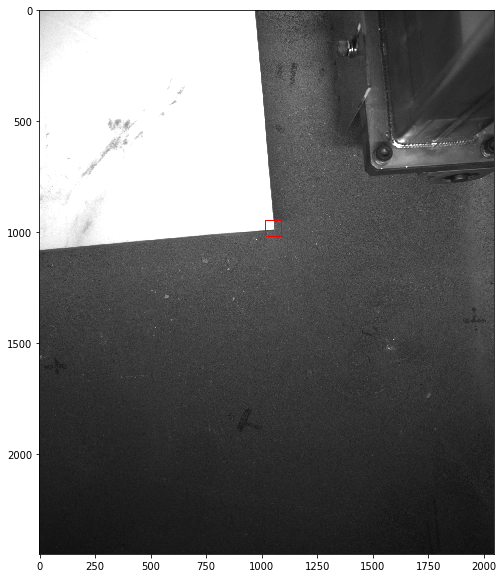

In [87]:
# 构造数据
image_path = "data/images/c52_20190910_162816.png"
image = cv2.imread(image_path)
train_input_size = [480, 480]
gt_boxes_lurb = np.array([[1021.74,947.284,1091.74,1017.288,1.65619,0]])
gt_boxes_xywh = lurb2xywh(gt_boxes_lurb)
print("gt_boxes_xywh:", gt_boxes_xywh)
# image = draw_rect_lurb(image, gt_boxes_lurb)
image = draw_rect_xywh(image, gt_boxes_xywh)
image_show(image)

# 测试 utils

### image_preporcess

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


gt_boxes_xywh: [[1056.74     982.286     70.        70.004      1.65619    0.     ]]
gt_boxes: [[246.20392157 192.60509804  52.7254902   13.72627451   1.65619
    0.        ]]


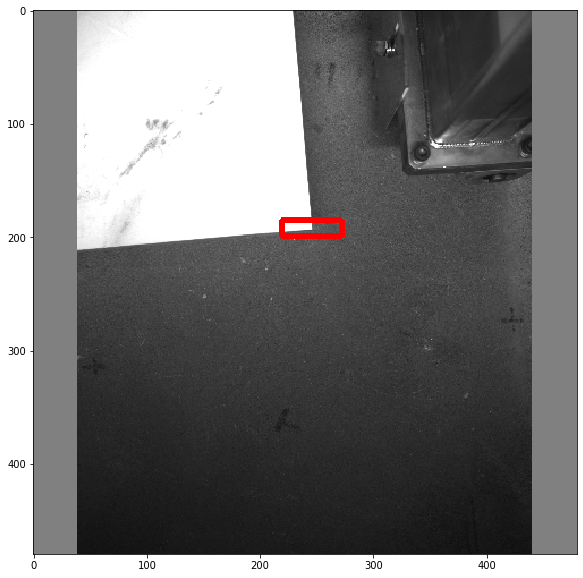

In [92]:
image_path = "data/images/c52_20190910_162816.png"
image = cv2.imread(image_path)
copy_gt_boxes_xywh = np.copy(gt_boxes_xywh)
image_paded, gt_boxes = utils.image_preporcess(image, train_input_size, copy_gt_boxes_xywh)
print("gt_boxes_xywh:", gt_boxes_xywh)
image_rect = draw_rect_xywh(image_paded, gt_boxes)
print("gt_boxes:", gt_boxes)
image_show(image_rect)

In [90]:
def rotate_rects(rects, rad_angle):
    """
        rects: np.array(), [[p1, p2, p3, p4], ...], 顺时针
                p:[x,y]
        rad_angle: 矩形框旋转角度，弧度制
    """
    rotate_matrix = np.matrix([[np.cos(rad_angle), -np.sin(rad_angle)], 
                              [np.sin(rad_angle), np.cos(rad_angle)]])
    
    rotate_rects = []
    for rect in rects:
        xy = np.matrix((rect[2] + rect[0]) * 0.5).T
        print("xy:", xy)
        rotate_rect = []
        for p in rect:
            r_p = rotate_matrix.T * np.matrix( np.matrix(p).T - xy) + xy
            rotate_rect.append(np.array(r_p))
        rotate_rects.append(np.array(rotate_rect))

    return np.array(rotate_rects)

xy: [[1056.74 ]
 [ 982.286]]
rotation_rect: [[[[1024.85068863]
   [1020.1437842 ]]

  [[1018.88039367]
   [ 950.39885193]]

  [[1088.62931137]
   [ 944.4282158 ]]

  [[1094.59960633]
   [1014.17314807]]]]


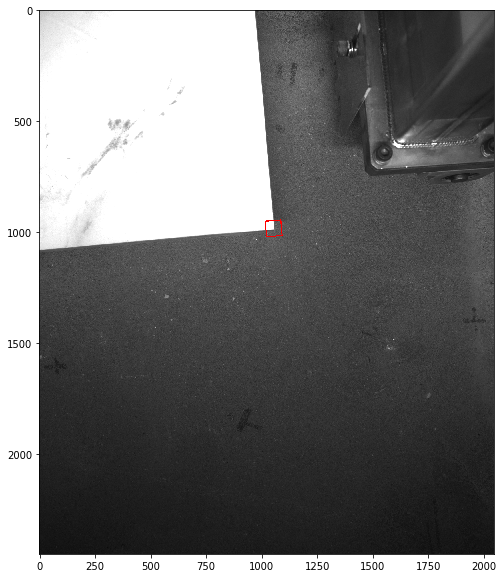

In [94]:
gt_rect = reflect_xywh2rect_v1(gt_boxes_xywh)
rotation_rect = rotate_rects(gt_rect, 1.65619)
image_rect = draw_rect_corner(image, rotation_rect)
print("rotation_rect:", rotation_rect)
image_show(image)

In [109]:
def calc_rotate_bbox_iou(bboxes1, bboxes2):
    """
        计算旋转框的iou，默认第一个为标注框，第二个为anchors
        
        input:
            bboxes1: np.array([[x,  y,  w ,  h, angle]])
            bboxes2: np.array([[x,  y,  w ,  h, angle],
                               [x,  y,  w ,  h, angle],
                               [x,  y,  w ,  h, angle]])
            
        
        return: np.array([iou_1, iou_2, iou_3, ...] ),
                例子：[0.13695256, 0.2936727 , 0.1788403 ]
            
    """
    def SutherlandHodgman(subjectPolygon, clipPolygon):
        """
            注意：点输入必须是顺时针
        """
        def inside(p):
            return(cp2[0] - cp1[0]) * (p[1] - cp1[1]) < (cp2[1] - cp1[1]) * (p[0] - cp1[0])

        def computeIntersection():
            dc = [cp1[0] - cp2[0], cp1[1] - cp2[1]]
            dp = [s[0] - e[0], s[1] - e[1]]
            n1 = cp1[0] * cp2[1] - cp1[1] * cp2[0]
            n2 = s[0] * e[1] - s[1] * e[0]
            n3 = 1.0 / (dc[0] * dp[1] - dc[1] * dp[0])
            return [(n1 * dp[0] - n2 * dc[0]) * n3, (n1 * dp[1] - n2 * dc[1]) * n3]

        outputList = subjectPolygon
        cp1 = clipPolygon[-1]

        for clipVertex in clipPolygon:
            cp2 = clipVertex
            inputList = outputList
            outputList = []
            try:
                s = inputList[-1]
            except Exception as e:
                return []

            for subjectVertex in inputList:
                e = subjectVertex
                if inside(e):
                    if not inside(s):
                        outputList.append(computeIntersection())
                    outputList.append(e)
                elif inside(s):
                    outputList.append(computeIntersection())
                s = e
            cp1 = cp2
        return outputList
    

    def polygon_area(P):
        """
            多边形面积
        """
        n = len(P)
        P.append(P[0])
        S = 0
        for i in range(0, n):
            S = S + (P[i][0] + P[i + 1][0]) * (P[i + 1][1] - P[i][1])
        return 0.5 * abs(S)
    
    
    def reflect_xywht2rect(bboxes):
        """
            将带有[x,y,w,h,angle]的bboxes转换为[p1, p2, p3, p4, angle]
            
            input:
                bboxes: np.array([[x,y,w,h,angle], [x,y,w,h,angle], ...])
            
            return:
                rects: np.array([[p1, p2, p3, p4, angle], [p1, p2, p3, p4, angle], ...])
                    p: list([x ,y])
                    angle: float
        """
        rects = []
        for bbox in bboxes:
            left_up = bbox[:2] - bbox[2:4] * 0.5
            right_bottom = bbox[:2] + bbox[2:4] * 0.5

            p1 = [left_up[0], left_up[1]]
            p2 = [left_up[1], right_bottom[0]]
            p3 = [right_bottom[0], right_bottom[1]]
            p4 = [left_up[0], right_bottom[1]]

            rects.append(np.array([p1, p2, p3, p4, bbox[-1]]))

        return np.array(rects)
    
    
    def rotate_rect(rects):
        """
            input:
                rects: np.array([[p1, p2, p3, p4, angle], ...])
            
            output:
                no angle rects: rects: np.array([[p1, p2, p3, p4], ...])
        """
        
        
    
    
    # 主程序
    iou = []
    
    # 计算面积
    rect_boxes1_area = list(bboxes1[..., 2] * bboxes1[..., 3])
    rect_boxes2_area = list(bboxes2[..., 2] * bboxes2[..., 3])
    
    # 计算矩形框
    rect_bboxes1 = reflect_xywht2rect(bboxes1)
    rect_bboxes2 = reflect_xywht2rect(bboxes2)
    print("rect_bboxes1:", rect_bboxes1)
    print("rect_bboxes2:", rect_bboxes2)
    
    
    
    # 旋转标注框
    rotate_bboxes1 = rotate_rect(rect_bboxes1)
    rotate_bboxes2 = rotate_rect(rect_bboxes2)
    
    for b1_index, box1 in enumerate(rotate_bboxes1):
        for b2_index, box2 in enumerate(rotate_bboxes2):
            # 计算重叠区域
            polygon = SutherlandHodgman(box1, box2)
            
            # 计算重叠区域面积
            if(len(polygon) != 0):
                S = polygon_area(polygon)
            else:
                S = 0
            
            union_area = rect_boxes1_area[b1_index] + rect_boxes2_area[b2_index] - S
            # 计算iou
            iou.append(S/union_area)
    
    
    return np.array(iou)

In [110]:
# 测试代码
bboxes1 = np.array([[17.1875,  3.4375,  2.125 ,  0.625, 1.65619]])
bboxes2 = np.array([[17.5       ,  3.5       ,  1.5298295 ,  4.26988649, 1.65619],
                    [17.5       ,  3.5       ,  3.72714543,  1.21338618, 1.65619],
                    [17.5       ,  3.5       ,  0.99446201,  2.78421688, 1.65619]])
iou = calc_rotate_bbox_iou(bboxes1, bboxes2)
print("iou:", iou)

rect_bboxes1: [[list([16.125, 3.125]) list([3.125, 18.25]) list([18.25, 3.75])
  list([16.125, 3.75]) 1.65619]]
rect_bboxes2: [[list([16.73508525, 1.365056755]) list([1.365056755, 18.26491475])
  list([18.26491475, 5.6349432450000005])
  list([16.73508525, 5.6349432450000005]) 1.65619]
 [list([15.636427285, 2.8933069099999997])
  list([2.8933069099999997, 19.363572715])
  list([19.363572715, 4.10669309]) list([15.636427285, 4.10669309])
  1.65619]
 [list([17.002768995, 2.10789156]) list([2.10789156, 17.997231005])
  list([17.997231005, 4.8921084399999994])
  list([17.002768995, 4.8921084399999994]) 1.65619]]


TypeError: 'NoneType' object is not iterable

# 测试 dataset

In [4]:
import core.dataset as dataset
angle = dataset.DatasetAngle('train')
annotations = angle.annotations[0]
print(annotations)

data/images\c52_20190910_164510.png 1006,942,1074,963,0 1055,885,1072,962,1


### parse_annotation

bboxes01: [[1.006e+03 9.420e+02 1.074e+03 9.630e+02 0.000e+00]
 [1.055e+03 8.850e+02 1.072e+03 9.620e+02 1.000e+00]]
bboxes: [[252.40522876 197.01960784 266.62745098 201.41176471   0.        ]
 [262.65359477 185.09803922 266.20915033 201.20261438   1.        ]]


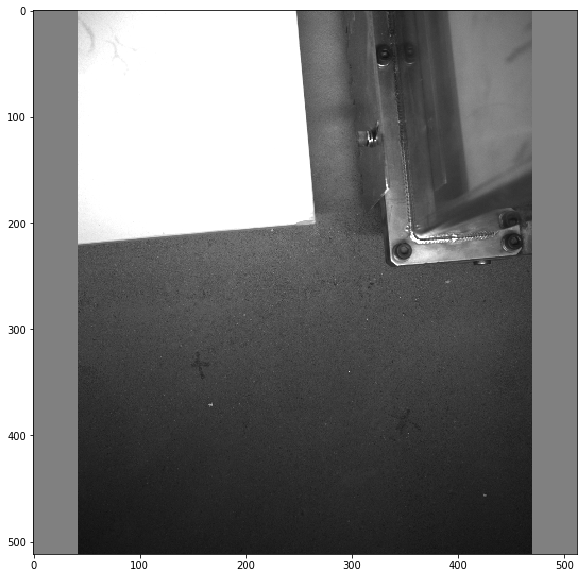

In [5]:
angle.train_input_size = np.random.choice(angle.train_input_sizes)
image, bboxes = angle.parse_annotation(annotations)
image_show(image)
print("bboxes:", bboxes)

### preprocess_true_boxes

### bbox_iou

In [7]:
# random_horizontal_flip
# random_crop
# random_translate